2025-01-01 17:04:02.359138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735718642.541064  175078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735718642.602004  175078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 17:04:02.875875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data length: 12
note length example: 460
mel_spectrogram shape:  (128, 4096)
mel_spectrogram graph


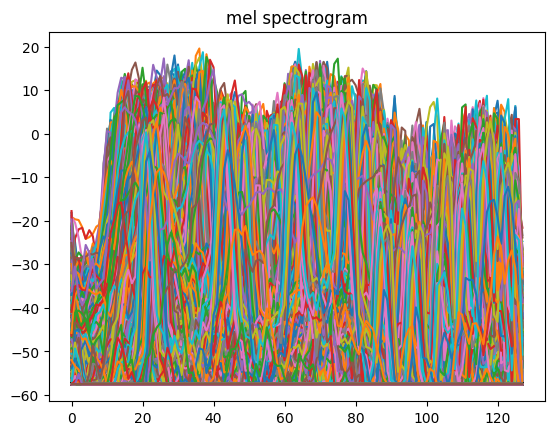

max_length:  6830
normalized y shape:  (128, 4096)
normalized y graph


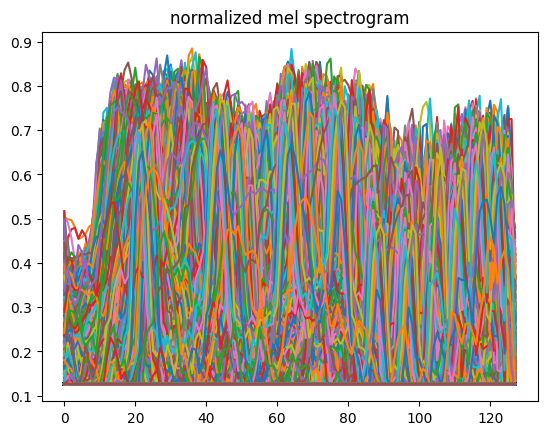

encoded y shape:  (110, 128, 4096)
max_lyric_index 237
building model...
train_lyric.shape (76, 784)
train_duration.shape (76, 784)
train_notenum.shape (76, 784)


I0000 00:00:1735718673.887953  175078 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


ValueError: The total size of the tensor must be unchanged. Received: input_shape=(784, 256), target_shape=(128, 4096)

In [1]:
from file_encoder import FileEncoder
from data_manager import DataManager
from audio_utils import SAMPLE_RATE, N_MELS
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam


TARGET_DIR = "../thirdparty/「波音リツ」歌声データベースVer2/DATABASE"
OUTPUT_DIR = "../master/ust/json"


need_encode = True

manager = DataManager()

if need_encode:
    encoder = FileEncoder(TARGET_DIR, OUTPUT_DIR)
    names, lyric_indexs, durations, notenums, y = encoder.encode()
    manager.save(lyric_indexs, durations, notenums, names, y)
    
lyric_indexs, duration_indexs, notenum_indexs, names, y = manager.load()
(train_lyric, train_duration, train_notenum), (test_lyric, test_duration, test_notenum), y_train, y_test = manager.get_train_and_test_data()

max_lyric_index = np.max(lyric_indexs)
print("max_lyric_index", max_lyric_index)

assert len(y) > 0 and len(lyric_indexs) > 0 and len(duration_indexs) > 0 and len(notenum_indexs) > 0

print("building model...")
# 入力データの形状を定義

#print("train_lyric", train_lyric)
#print("train_duration.", train_duration)
#print("train_notenum", train_notenum)


print("train_lyric.shape", train_lyric.shape)
print("train_duration.shape", train_duration.shape)
print("train_notenum.shape", train_notenum.shape)

lyric_input = tf.keras.Input(shape=train_lyric.shape[1:], name="lyric_input", dtype="int32")
duration_input = tf.keras.Input(shape=train_duration.shape[1:], name="duration_input", dtype="float32")
notenum_input = tf.keras.Input(shape= train_notenum.shape[1:], name="notenum_input", dtype="float32")

# Embedding 層
lyric_embedded = layers.Embedding(input_dim=max_lyric_index + 1, output_dim=128)(lyric_input)

duration_reshaped = layers.Reshape((-1, 1))(duration_input)  # (batch_size, 784, 1)
notenum_reshaped = layers.Reshape((-1, 1))(notenum_input)    # (batch_size, 784, 1)

# 入力を結合
merged = layers.Concatenate()([lyric_embedded, duration_reshaped, notenum_reshaped])

# LSTM 層
lstm_out = layers.LSTM(256, return_sequences=True)(merged)
lstm_out = layers.LSTM(256, return_sequences=True)(lstm_out)

# 出力層: 13660 フレーム × 128 次元（n_mels）
n_mels = 128  # メルスペクトログラムの周波数次元
output = layers.Dense(256)(lstm_out)
output = layers.Reshape(y_train.shape[1:])(output)

# モデルの構築
model = tf.keras.Model(
    inputs=[lyric_input, duration_input, notenum_input],
    outputs=output,
    name="vocaloid_model"
)

optimizer = Adam()

model.compile(
    optimizer=optimizer, 
    loss='mse',
    metrics=['mae']
)

model.summary()

model.fit(
    [train_lyric, train_duration, train_notenum],  # 入力データ（リスト形式）
    y_train,  # 出力データ
    batch_size=32,
    epochs=20,
)

manager.save_model(model)

print("Done!")

In [3]:
4096 * 128 / 2048

256.0

In [2]:
256 * 16

4096